In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit
from abc import ABC, abstractmethod
from matplotlib import cm

In [2]:
np.random.seed(2)

In [3]:
DIVERGENCE_VALUE = 10
MAX_ITERATIONS = 10000

In this notebook, I implement several gradient descent algorithms and I apply them to three different loss functions both for two-dimensional and one-dimensional data. 1D loss functions are based on slicing the original 2D loss function after fixing the value of one of the parameters. 

These are the methods implemented in this notebook:

* Steepest gradient descent
* Newton-Raphson
* Learning rate annealing
* Adagrad
* Stochastic gradient descent
* Mini-batch gradient descent

The second notebook in this folder implements linear conjugate gradient descent, which is then applied to fit the parameters of a linear regression model. 

## Methods implementation

All the gradient descent methods are implemented in a single abstract class. We derive three subclasses from this abstract class, one for each loss function. The only specific methods that have to be implemented by each loss function class are those related to calculating gradients and hessians, creating a dataset and plotting the data and the model. 

### General abstract base class

In [4]:
class AbstractLoss(ABC):
 
    def __init__(self, p1lim, p2lim, granularity = 1000):
        '''
        Class constructor. Given the range of values for the two parameters, it initialises
        a granularity x granularity grid. 
        
        Parameters:
           - p1lim: a list containing the minimum and maximum values for the first parameter
           - p2lim: a list containing the minimum and maximum values for the second parameter
           - granularity: grid resolution (default value is 1000)
        '''
        # Storing parameters
        self.granularity = granularity
        # Preprocess data
        self.p = [np.linspace(p1lim[0], p1lim[1], granularity), 
                  np.linspace(p2lim[0], p2lim[1], granularity)]
        self.p1p1, self.p2p2 = np.meshgrid(*self.p)
        
        super().__init__()
     
    ###############################
    ### Abstract methods: start ###
    @abstractmethod
    def _calculate_gradient(self, x, y, current_params):
        pass
    
    @abstractmethod
    def _calculate_hessian(self, x, y, current_params):
        pass
    
    @abstractmethod
    def produce_dataset(self):
        pass
    
    @abstractmethod
    # Grid approximation if params = None, otherwise, calculate for a specific combination of parameters
    def calculate_loss_2D(self, params = None):
        pass
    
    @abstractmethod
    def _plot_model(self, *args):
        pass
    ### Abstract methods: end ###
    #############################
    
    ############################################
    ### Auxiliary functions (general): start ### 
    def _plot_gradient_steps(self, ax, p1_values, p2_values):
        ax.plot(p1_values, 
                p2_values, 
                marker = 'x', 
                linestyle = '-', 
                color = 'r', 
                markerfacecolor = 'r', 
                markeredgecolor = 'r')
    
    def _plot_grid_search_minimum(self, ax, value1, value2):
        ax.plot(value1, 
                value2, 
                markerfacecolor = 'red', 
                markeredgecolor = 'red', 
                marker = 'x', 
                markersize = 5)
        
    def _validate_input_gradient(self, learning_rates, method, batch_size):
        if not type(learning_rates) == list:
            raise ValueError('Learning rates have to be provided in a list')
            
        if method == 'minibatch' and (batch_size < 0 or batch_size > self.x.shape[0]):
            raise ValueError('Batch size should be between one and training set\'s size')
            
        if method == 'steepest':
            caption_0 = 'Steepest gradient descent\n'
        elif method == 'annealing':
            caption_0 = 'Steepest gradient descent with annealing\n'
        elif method == 'newton':
            caption_0 = 'Newton\'s optimisation method\n'
        elif method == 'adagrad':
            caption_0 = 'AdaGrad\n'
        elif method == 'sgd':
            caption_0 = 'Stochastic gradient descent\n'
        elif method == 'minibatch':
            caption_0 = 'Mini-batch gradient descent\n'
        else:
            raise ValueError('Incorrect gradient descent method value')
            
        return caption_0
    
    def _init_plotting_gradient(self, learning_rates, width):
        rows = int((len(learning_rates) + 1) / 2)
        fig, ax = plt.subplots(rows, 2)
        fig.set_figwidth(width)
        fig.set_figheight(5 * rows)
        r = 0
        c = 0
        
        return fig, ax, rows, r, c
    
    def _select_gradient(self, method, order, pos, batch_size, current_params, axis = None):
        if method =='sgd' or method == 'minibatch':
            if method == 'sgd':
                gradient = self._calculate_gradient(np.array([self.x[order[pos]]]), 
                                                    np.array([self.y[order[pos]]]), 
                                                    current_params)
                pos = pos + 1
            else:
                gradient = self._calculate_gradient(self.x[order[pos:min(pos + batch_size, 
                                                                         self.x.shape[0])]], 
                                                    self.y[order[pos:min(pos + batch_size,
                                                                          self.x.shape[0])]], 
                                                    current_params)
                pos = pos + batch_size
            if pos >= self.x.shape[0]:
                np.random.shuffle(order)
                pos = 0
        else:
            gradient = self._calculate_gradient(self.x, self.y, current_params)
        
        if axis is None:
            gradient = np.array(gradient)
        else:
            gradient = gradient[axis]
                
        return pos, gradient
            
    ### Auxiliary functions (general): end ###
    ##########################################
    
    #######################################
    ### Auxiliary functions (2D): start ###
    def _plot_loss_2D(self, fig, ax):
        ax.contourf(self.p[0], self.p[1], self.l, cmap = cm.coolwarm, alpha = 0.5)
        ax.set_xlabel(self.param_names[0])
        ax.set_ylabel(self.param_names[1])
        ax.set_xlim([np.min(self.p[0]), np.max(self.p[0])])
        ax.set_ylim([np.min(self.p[1]), np.max(self.p[1])])
    
    def _plot_gradient_descent_2D(self, fig, ax, caption, values):
        self._plot_loss_2D(fig, ax) 
        self._plot_gradient_steps(ax, values[:, 0], values[:, 1]) 
        ax.set_title(caption)
    ### Auxiliary functions (2D): end ###
    #####################################
    
    #######################################
    ### Auxiliary functions (1D): start ###
    def _plot_loss_1D(self, fig, ax, axis, index):
        if axis == 0:
            self.l1d = self.l[index, :]
        elif axis == 1:
            self.l1d = self.l[:, index]
        else:
            raise ValueError('Incorrect axis value')
        x = self.p[axis]
    
        ax.plot(x, self.l1d)
        ax.set_xlabel(self.param_names[axis])
        ax.set_ylabel('loss')
        ax.set_xlim([np.min(x), np.max(x)])
        ax.set_ylim([np.min(self.l1d), np.max(self.l1d)])
        ax.set_title(self.param_names[1 - axis] + ' = ' + str(self.p[1 - axis][index]))
    
    def _plot_gradient_descent_1D(self, fig, ax, caption, axis, index, values):
        if axis == 0:
            other = self.p[1][index]
        else:
            other = self.p[0][index]
        caption = 'Fixed parameter ' + ax.get_title() + '\n' + caption
        values_other = [self.calculate_loss_2D([v, other]) for v in values]
        
        self._plot_loss_1D(fig, ax, axis, index)
        self._plot_gradient_steps(ax, values[:], values_other) 
        ax.set_title(caption)
    ### Auxiliary functions (1D): end ###
    #####################################  
    
    #########################
    ### 2D methods: start ###
    def gridsearch_loss_2D(self):
        fig, ax = plt.subplots()
        self._plot_loss_2D(fig, ax)
        
        minimum = np.unravel_index(np.argmin(self.l), self.l.shape)
        print('Gridsearch minimum:')
        print(self.param_names[0] + ': ' + str(self.p1p1[minimum]))
        print(self.param_names[1] + ': ' + str(self.p2p2[minimum]))
        print('Loss function value: ' + str(self.l[minimum]))
        self._plot_grid_search_minimum(ax, self.p1p1[minimum], self.p2p2[minimum])
        
        self._plot_model(self.p1p1[minimum], self.p2p2[minimum])
    ### 2D methods: end ###
    #######################
        
    #########################
    ### 1D methods: start ###
    def gridsearch_loss_1D(self, axis, index):
        fig, ax = plt.subplots()
        self._plot_loss_1D(fig, ax, axis, index)

        minimum = np.argmin(self.l1d)
        print('Gridsearch minimum:')
        print(self.param_names[axis] + ': ' + str(self.p[axis][minimum]))
        print('Loss function value: ' + str(self.l1d[minimum]))
        self._plot_grid_search_minimum(ax, self.p[axis][minimum], self.l1d[minimum])
    ### 1D methods: end ###
    #######################
        
    def gradient_descent_2D(self, 
                            initial_p1_index,
                            initial_p2_index,
                            learning_rates = [0.01], 
                            stop_threshold = 0.0001,
                            method = 'steepest',
                            batch_size = 2):
        
        caption_0 = self._validate_input_gradient(learning_rates, method, batch_size)
        
        fig, ax, rows, r, c = self._init_plotting_gradient(learning_rates, 13)
        
        for learning_rate in learning_rates:
            it = 0
            params_history = [[initial_p1_index + stop_threshold, 
                               initial_p2_index + stop_threshold]]
            current_params = [initial_p1_index, initial_p2_index]
            learning_rate_0 = learning_rate # For annealing
            z = np.array([0, 0]) # for adagrad, if required
            # For stochastic gradient descent, if required
            order = np.arange(self.x.shape[0]) 
            np.random.shuffle(order)
            pos = 0  

            while np.sum(np.abs(np.array(current_params) - np.array(params_history[-1]))) > stop_threshold and \
                  np.all(np.array(current_params) - np.array(params_history[-1]) < DIVERGENCE_VALUE) and \
                  it < MAX_ITERATIONS:
                params_history.append(current_params)
                
                pos, gradient = self._select_gradient(method, order, pos, batch_size, current_params)
                    
                if method == 'steepest' or method == 'annealing' or method == 'sgd' or method == 'minibatch':
                    if method == 'annealing':
                        learning_rate = learning_rate_0 / float(len(params_history))
                    step = learning_rate * gradient
                elif method == 'newton':
                    hessian_inv = np.linalg.inv(self._calculate_hessian(self.x, self.y, current_params))
                    step = np.matmul(hessian_inv, gradient)  
                elif method == 'adagrad':
                    z = z + np.multiply(gradient, gradient)
                    step = learning_rate * gradient / np.sqrt(z + 0.0001)
                    
                current_params = (np.array(current_params) - step).tolist()
                it = it + 1
            params_history.append(current_params)
                
            caption = caption_0 + 'Learning rate = ' + str(learning_rate) 
            caption = caption + ' (' +  str(len(params_history) - 1) + ' iterations)\n'
            if it == MAX_ITERATIONS:
                caption = caption + '   Algorithm interrupted - maximum iterations reached\n'
            elif np.any(np.array(current_params) - np.array(params_history[-2]) >= DIVERGENCE_VALUE):
                caption = caption + '   Algorithm interrupted - divergence detected\n'
            
            caption = caption + self.param_names[0] + ': ' + str(current_params[0]) + '\n'
            caption = caption + self.param_names[1] + ': ' + str(current_params[1]) + '\n'
            caption = caption + 'Loss function value: ' + str(self.calculate_loss_2D(current_params))
            
            if rows == 1:
                ax_i = ax[c]
            else:
                ax_i = ax[r][c]
            self._plot_gradient_descent_2D(fig, ax_i, caption, np.array(params_history[1:]))
            c = c + 1
            if c > 1:
                c = 0
                r = r + 1               
        plt.tight_layout()
        if c == 1:
            if rows == 1:
                ax[c].axis('off')
            else:
                ax[r][c].axis('off')
        
    def gradient_descent_1D(self, 
                            axis, 
                            index, 
                            initial_p_index, 
                            learning_rates = [0.01], 
                            stop_threshold = 0.0001,
                            method = 'steepest',
                            batch_size = 2):
        
        caption_0 = self._validate_input_gradient(learning_rates, method, batch_size)
            
        fig, ax, rows, r, c = self._init_plotting_gradient(learning_rates, 11)
        
        # The incorrect index value exception is already raised in the plot_loss_1D function
        if axis == 0:
            self.l1d = self.l[index, :]
            other = self.p[1][index]
            name = self.param_names[0]
        else:
            self.l1d = self.l[:, index]
            other = self.p[0][index]
            name = self.param_names[1]
            
        for learning_rate in learning_rates:
            it = 0
            current_params = [initial_p_index, other]
            params_history = [[initial_p_index + 2 * stop_threshold, other]]
            learning_rate_0 = learning_rate # for annealing
            z = 0 # For adagrad, if required
            # For stochastic gradient descent, if required
            order = np.arange(self.x.shape[0]) 
            np.random.shuffle(order)
            pos = 0

            while math.fabs(current_params[0] - params_history[-1][0]) > stop_threshold and \
                  current_params[0] - params_history[-1][0] < DIVERGENCE_VALUE and \
                  it < MAX_ITERATIONS:
                params_history.append(current_params)
                
                pos, gradient = self._select_gradient(method, order, pos, batch_size, current_params, axis)
                
                if method == 'steepest' or method == 'annealing' or method == 'sgd' or method == 'minibatch':
                    if method == 'annealing':
                        learning_rate = learning_rate_0 / float(len(params_history))
                    step = learning_rate * gradient
                elif method == 'newton':
                    hessian_inv = 1/(np.array([self._calculate_hessian(self.x, 
                                                                       self.y, 
                                                                       current_params)[axis][axis]]))
                    step = hessian_inv * gradient
                elif method == 'adagrad':
                    z = z + gradient ** 2
                    step = learning_rate * gradient / math.sqrt(z + 0.0001)
                
                current_params = [current_params[0] - step, other]
                it = it + 1
            params_history.append(current_params)

            caption = caption_0 + 'Learning rate = ' + str(learning_rate) 
            caption = caption + ' (' +  str(len(params_history) - 1) + ' iterations)\n'
            if it == MAX_ITERATIONS:
                caption = caption + '   Algorithm interrupted - maximum iterations reached\n'
            elif current_params[0] - params_history[-2][0] >= DIVERGENCE_VALUE:
                caption = caption + '   Algorithm interrupted - divergence detected\n'
            caption = caption + self.param_names[axis] + ': ' + str(current_params[0]) + '\n'
            caption = caption + 'Loss function value: ' + str(self.calculate_loss_2D(current_params))
            
            if rows == 1:
                ax_i = ax[c]
            else:
                ax_i = ax[r][c]
            self._plot_gradient_descent_1D(fig, ax_i, caption, axis, index, np.array(params_history)[1:, 0])
            c = c + 1
            if c > 1:
                c = 0
                r = r + 1
        plt.tight_layout()
        if c == 1:
            if rows == 1:
                ax[c].axis('off')
            else:
                ax[r][c].axis('off') 

### Linear regression loss function implementation

$L = \frac{1}{n}\displaystyle\sum_i(y_i - \beta_0 - \beta_1 x_i)^2$

$\frac{\partial L}{\partial \beta_1} = - \frac{1}{n}\displaystyle\sum_i2x_i(y_i - \beta_0 - \beta_1 x_i)$

$\frac{\partial L}{\partial \beta_0} = - \frac{1}{n}\displaystyle\sum_i2(y_i - \beta_0 - \beta_1 x_i)$

$\frac{\partial L}{\partial \beta_1 \partial \beta_1} = \frac{1}{n}\displaystyle\sum2x_i^2$

$\frac{\partial L}{\partial \beta_1 \partial \beta_0} = \frac{1}{n}\displaystyle\sum2x_i$

$\frac{\partial L}{\partial \beta_0 \partial \beta_1} = \frac{1}{n}\displaystyle\sum2x_i$

$\frac{\partial L}{\partial \beta_0 \partial \beta_0} = 2$

In [5]:
class LinearRegressionLoss(AbstractLoss):
    def __init__(self, xlim, b0, b1, n, p1lim, p2lim, granularity = 1000):
        super().__init__(p1lim, p2lim, granularity)
        self.param_names = ['b0', 'b1']
        self.xlim = xlim
        self.b0 = b0
        self.b1 = b1
        self.n = n
        
    def _calculate_gradient(self, x, y, current_params):
        # Partial derivative with respect to b_1
        d_b1 = np.mean(np.multiply(-2 * x, y - current_params[0] - current_params[1] * x))
        # Partial derivative with respect to b_0
        d_b0 = np.mean(-2 * (y - current_params[0] - current_params[1] * x))

        return [d_b0, d_b1]
    
    def _calculate_hessian(self, x, y, current_params):
        # Partial derivative with respect to b_1 b_1
        d_b1_b1 = np.mean(2 * np.power(x, 2))
        # Partial derivative with respect to b_1 b_0
        d_b1_b0 = np.mean(2 * x)
        # Partial derivative with respect to b_0 b_1
        d_b0_b1 = d_b1_b0
        # Partial derivative with respect to b_0 b_0
        d_b0_b0 = 2
        
        return [[d_b0_b0, d_b0_b1], [d_b1_b0, d_b1_b1]]
    
    def produce_dataset(self):
        self.x = np.linspace(self.xlim[0], self.xlim[1], self.n)
        self.y = self.b1 * self.x + self.b0 + np.random.rand(self.n)
        
    def calculate_loss_2D(self, params = None):
        xp = np.vstack((np.ones((1, self.x.shape[0])), self.x)).T
        if params is None:
            b = np.vstack((self.p1p1.flatten(), self.p2p2.flatten()))
            yp = np.dot(xp, b)
            yl = np.repeat(self.y, self.granularity * self.granularity) \
                   .reshape(self.y.shape[0], self.granularity * self.granularity)
            self.l = np.mean(np.power(yl - yp, 2), axis = 0).reshape(self.granularity, self.granularity)
        else:
            yp = np.dot(xp, params)
            return np.mean(np.power(self.y - yp, 2), axis = 0)
            
        
    def _plot_model(self, *args):
        fig, ax = plt.subplots()
        ax.plot(self.x, self.y, 'o')
        ax.plot(self.x, self.x * args[1] + args[0])
        ax.set_title('beta_0 = ' + str(args[0].round(2)) + ', beta_1 = ' + str(args[1].round(2)))

### Logistic regression loss function implementation

$L = -\displaystyle\prod_i \left(\frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}\right)^{y_i} \left({1 - \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}}\right) ^ {1 - y_i} $

$\log(L) = -\displaystyle\sum_i y\log\left(\frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}\right) + (1-y_i)\log\left({1 - \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}}\right) $

$\frac{\partial \log(L)}{\partial \beta_0} = -\displaystyle\sum_i\frac{y_i-(1-y_i)e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$

$\frac{\partial \log(L)}{\partial \beta_1} = -\displaystyle\sum_i\frac{y_i x_i-(1-y_i)x_ie^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$

$\frac{\partial \log(L)}{\partial \beta_0 \partial \beta_0} = \displaystyle\sum_i\frac{e^{\beta_0 + \beta_1 x_i}}{(1 + e^{\beta_0 + \beta_1 x_i})^2}$

$\frac{\partial \log(L)}{\partial \beta_0 \partial \beta_1} = \displaystyle\sum_i\frac{x_i e^{\beta_0 + \beta_1 x_i}}{(1 + e^{\beta_0 + \beta_1 x_i})^2}$

$\frac{\partial \log(L)}{\partial \beta_1 \partial \beta_0} = \displaystyle\sum_i\frac{x_ie^{\beta_0 + \beta_1 x_i}}{(1 + e^{\beta_0 + \beta_1 x_i})^2}$

$\frac{\partial \log(L)}{\partial \beta_1 \partial \beta_1} = \displaystyle\sum_i\frac{x_i^2 e^{\beta_0 + \beta_1 x_i}}{(1 + e^{\beta_0 + \beta_1 x_i})^2}$

In [6]:
class LogisticRegressionLoss(AbstractLoss):
    def __init__(self, mu1, std1, n1, mu2, std2, n2, p1lim, p2lim, granularity = 1000):
        super().__init__(p1lim, p2lim, granularity)
        self.param_names = ['b0', 'b1']
        self.mu1 = mu1
        self.std1 = std1
        self.n1 = n1
        self.mu2 = mu2
        self.std2 = std2
        self.n2 = n2
    
    def _calculate_gradient(self, x, y, current_params):
        e = np.exp(current_params[0] + current_params[1] * x)
        d_b1 = - np.sum(np.divide(np.multiply(y, x) - np.multiply(np.multiply(x, 1 - y), e), 1 + e))
        d_b0 = - np.sum(np.divide(y - np.multiply(1 - y, e), 1 + e))
       
        return [d_b0, d_b1]
    
    def _calculate_hessian(self, x, y, current_params):
        e = np.exp(current_params[0] + current_params[1] * x)
        e2 = np.power(1 + e, 2)
        d_b1_b1 = np.sum(np.divide(np.multiply(np.power(x, 2), e), e2))
        d_b1_b0 = np.sum(np.divide(np.multiply(x, e), e2))
        d_b0_b1 = d_b1_b0
        d_b0_b0 = np.sum(np.divide(e, e2))

        return([[d_b0_b0, d_b0_b1], [d_b1_b0, d_b1_b1]])
        
    def produce_dataset(self):
        self.x = np.hstack((np.random.normal(loc = self.mu1, scale = self.std1, size = self.n1),
                            np.random.normal(loc = self.mu2, scale = self.std2, size = self.n2)))
        self.y = np.hstack((np.zeros(self.n1), np.ones(self.n2)))
        
    def calculate_loss_2D(self, params = None):
        xp = np.vstack((np.ones((1, self.x.shape[0])), self.x)).T   
        if params is None:
            b = np.vstack((self.p1p1.flatten(), self.p2p2.flatten()))
            yp = np.exp(np.dot(xp, b))/(1 + np.exp(np.dot(xp, b)))
            yl = np.repeat(self.y, self.granularity * self.granularity) \
                   .reshape(self.y.shape[0], self.granularity * self.granularity)

            # Taking the negative of the loss function so it becomes a minimisation problem
            self.l = -np.sum(np.multiply(yl, np.log(yp)) + np.multiply(1 - yl, np.log(1 - yp)), axis = 0) \
                        .reshape(self.granularity, self.granularity)
        else:
            yp = np.exp(np.dot(xp, params))/(1 + np.exp(np.dot(xp, params)))
            return -np.sum(np.multiply(self.y, np.log(yp)) + np.multiply(1 - self.y, np.log(1 - yp)))
        
    def _plot_model(self, *args):
        fig, ax = plt.subplots()
        
        ax.plot(self.x, self.y, 'o')
        
        if self.mu1 < self.mu2:
            mu1, mu2, std1, std2 = self.mu1, self.mu2, self.std1, self.std2
        else:
            mu1, mu2, std1, std2 = self.mu2, self.mu1, self.std1, self.std1
        xl = np.linspace(mu1 - 3 * std1, mu2 + 3 * std2, self.granularity)
        p = np.exp(xl * args[1] + args[0]) / (1 + np.exp(xl * args[1] + args[0]))
        ax.plot(xl, p)

### Styblinski-Tang regression loss function implementation

We need a loss function with local minima.

Styblinski-Tang function - https://www.sfu.ca/~ssurjano/stybtang.html

Partial derivatives https://es.symbolab.com/solver/partial-derivative-calculator/

Minimum at (-3, -3)

The original Styblinkski-Tang function:

$f(\vec{\beta}) = \frac{1}{2}\displaystyle\sum_{i=1}^{d}(\beta_i^4-16\beta_i^2+5\beta_i)$

The minimum is located at $\beta_1 = \beta_2 = -2.91$.  

We build a simple linear regression model with a single input variable (the actual value of the coefficients is given by the minimum values in the previous paragraph):

$y = \frac{1}{2}\displaystyle\sum_{i=1}^{2}(\beta_i^4-16\beta_i^2+5\beta_i) x$

Therefore:

$L = \frac{1}{n}\displaystyle\sum_i\left[y_i - \frac{1}{2}\displaystyle\sum_{i=1}^{2}(\beta_i^4-16\beta_i^2+5\beta_i) x_i\right]^2$

$\frac{\partial L}{\partial \beta_1} = - \frac{1}{n}\displaystyle\sum_i x_i \left(4 \beta_1^3-32\beta_1+5\right)\left(y_i - \frac{1}{2}\displaystyle\sum_{j=1}^{2}(\beta_j^4-16\beta_j^2+5\beta_j) x_i\right)$

$\frac{\partial L}{\partial \beta_2} = - \frac{1}{n}\displaystyle\sum_i x_i \left(4 \beta_2^3-32\beta_2+5\right)\left(y_i - \frac{1}{2}\displaystyle\sum_{i=j}^{2}(\beta_j^4-16\beta_j^2+5\beta_j) x_i\right)$

$\frac{\partial L}{\partial \beta_1 \beta_1} = - \frac{1}{n}\displaystyle\sum_i x_i\left(-14x_i\beta_1^6+240x_i\beta_1^4-50x_i\beta_1^3-768x_i\beta_1^2+240x_i\beta_1-6x_i\beta_1^2\beta_2^4+16x_i\beta_2^4+96x_i\beta_1^2\beta_2^2-256x_i\beta_2^2-30x_i\beta_1^2\beta_2+80x_i\beta_2-12.5x_i-32y_i+12y_i\beta_1^2\right)$

$\frac{\partial L}{\partial \beta_1 \beta_2} = \frac{1}{n}\displaystyle\sum_i \frac{x_i^2\displaystyle\prod_{j=1}^2(4\beta_j^3-32\beta_j+5)}{2}$

$\frac{\partial L}{\partial \beta_2 \beta_2} = - \frac{1}{n}\displaystyle\sum_i x_i\left(-14x_i\beta_2^6+240x_i\beta_2^4-50x_i\beta_2^3-768x_i\beta_2^2+240x_i\beta_2-6x_i\beta_2^2\beta_1^4+16x_i\beta_1^4+96x_i\beta_2^2\beta_1^2-256x_i\beta_1^2-30x_i\beta_2^2\beta_1+80x_i\beta_1-12.5x_i-32y_i+12y_i\beta_2^2\right)$

$\frac{\partial L}{\partial \beta_2 \beta_1} = \frac{1}{n}\displaystyle\sum_i \frac{x_i^2\displaystyle\prod_{j=1}^2(4\beta_j^3-32\beta_j+5)}{2}$

In [7]:
B1 = -2.91
B2 = -2.91
N = 100

class StyblinskiTangLoss(AbstractLoss):
    def __init__(self, p1lim, p2lim, granularity = 1000):
        super().__init__(p1lim, p2lim, granularity)
        self.param_names = ['b1', 'b2']
        
    def _calculate_gradient(self, x, y, current_params):
        # Both derivatives share the rightmost part
        diff = 0
        for i in range(2):
            diff = diff +  (current_params[i] ** 4 - 16 * current_params[i] ** 2 + 5 * current_params[i]) * x
        diff = y - 0.5 * diff
        # Partial derivative with respect to b_1
        d_b1 = -np.mean(np.multiply(x, 
                                    np.multiply(4 * current_params[0] ** 3 - 32 * current_params[0] + 5, 
                                                diff)))
        # Partial derivative with respect to b_2
        d_b2 = -np.mean(np.multiply(x, 
                                    np.multiply(4 * current_params[1] ** 3 - 32 * current_params[1] + 5, 
                                                diff)))

        return [d_b1, d_b2]
    
    def _calculate_hessian(self, x, y, current_params):
        # Shared calculations
        prod = 1
        for i in range(2):
            prod = prod * (4 * current_params[i] ** 3 - 32 * current_params[i] + 5)
        # Partial derivative with respect to b_1 b_1
        def _d_bx_bx(x, y, current_params, i):
            return -np.mean(np.multiply(x,
                                       -14 * current_params[i] ** 6 * x + \
                                       240 * current_params[i] ** 4 * x - \
                                       50 * current_params[i] ** 3 * x - \
                                       768 * current_params[i] ** 2 * x + \
                                       240 * current_params[i] * x - \
                                       6 * current_params[i] ** 2 * current_params[abs(1 - i)] ** 4 * x + \
                                       16 * current_params[abs(1 - i)] ** 4 * x + \
                                       96 * current_params[i] ** 2 * current_params[abs(1 - i)] ** 2 * x - \
                                       256 * current_params[abs(1 - i)] ** 2 * x - \
                                       30 * current_params[i] ** 2 * current_params[abs(1 - i)] * x + \
                                       80 * current_params[abs(1 - i)] * x - \
                                       12.5 * x - \
                                       32 * y + \
                                       1224 * y * current_params[i] ** 2))
        d_b2_b2 = _d_bx_bx(x, y, current_params, 1)
        # Partial derivative with respect to b_1 b_0
        d_b2_b1 = np.mean(np.power(x, 2) * prod / 2)
        # Partial derivative with respect to b_0 b_1
        d_b1_b2 = np.mean(np.power(x, 2) * prod / 2)
        # Partial derivative with respect to b_1 b_1
        d_b1_b1 = _d_bx_bx(x, y, current_params, 0)
        
        return [[d_b1_b1, d_b1_b2], [d_b2_b1, d_b2_b2]]
        
    def produce_dataset(self):
        self.x = np.array(range(1, N + 1))
        self.y = (np.power(B1, 4) - 16 * np.power(B1, 2) + 5 * B1) * self.x
        self.y = self.y + (np.power(B2, 4) - 16 * np.power(B2, 2) + 5 * B2) * self.x
        self.y = 0.5 * self.y + 100 * np.random.rand(N)
        
    def calculate_loss_2D(self, params = None):
        xp = np.vstack((self.x, self.x)).T
        if params is None:
            b = np.vstack((self.p1p1.flatten(), self.p2p2.flatten()))
            b = np.power(b, 4) - 16 * np.power(b, 2) + 5 * b
            yp = 0.5 * np.dot(xp, b)
            yl = np.repeat(self.y, self.granularity * self.granularity) \
                   .reshape(self.y.shape[0], self.granularity * self.granularity)
            self.l = np.mean(np.power(yl - yp, 2), axis = 0).reshape(self.granularity, self.granularity)
        else:
            b = np.power(params, 4) - 16 * np.power(params, 2) + 5 * np.array(params)
            yp = 0.5 * np.dot(xp, b)
            return np.mean(np.power(self.y - yp, 2), axis = 0)
        
    def _plot_model(self, *args):
        # This is not important for this particular example
        pass

## Linear regression results

Note: the estimation of b_0 and b_1 may differ from the constants due to the introduced noise. 

In [8]:
lrl = LinearRegressionLoss(xlim = [-1, 2],
                           b0 = 0.6,
                           b1 = 1.7,
                           n = 11,
                           p1lim = [-10, 10],
                           p2lim = [-10, 10])

In [9]:
lrl.produce_dataset()

In [10]:
lrl.calculate_loss_2D()

Gridsearch minimum:
b0: 0.9709709709709706
b1: 1.7317317317317311
Loss function value: 0.02866812734932108


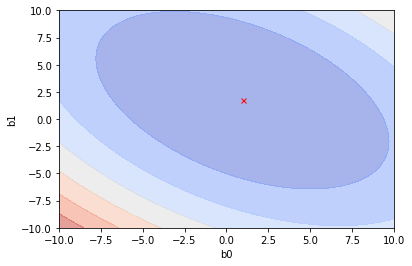

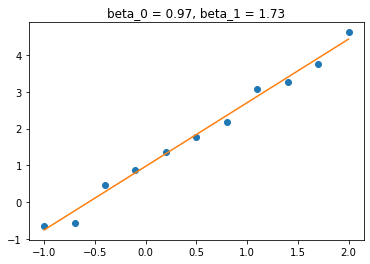

In [11]:
lrl.gridsearch_loss_2D()

Gridsearch minimum:
b0: 0.9709709709709706
Loss function value: 0.02866812734932108


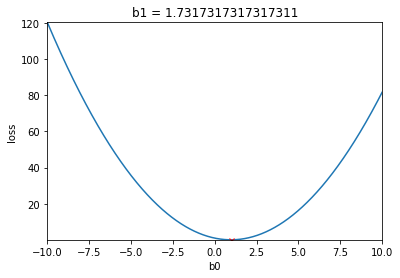

In [12]:
lrl.gridsearch_loss_1D(0, 586)

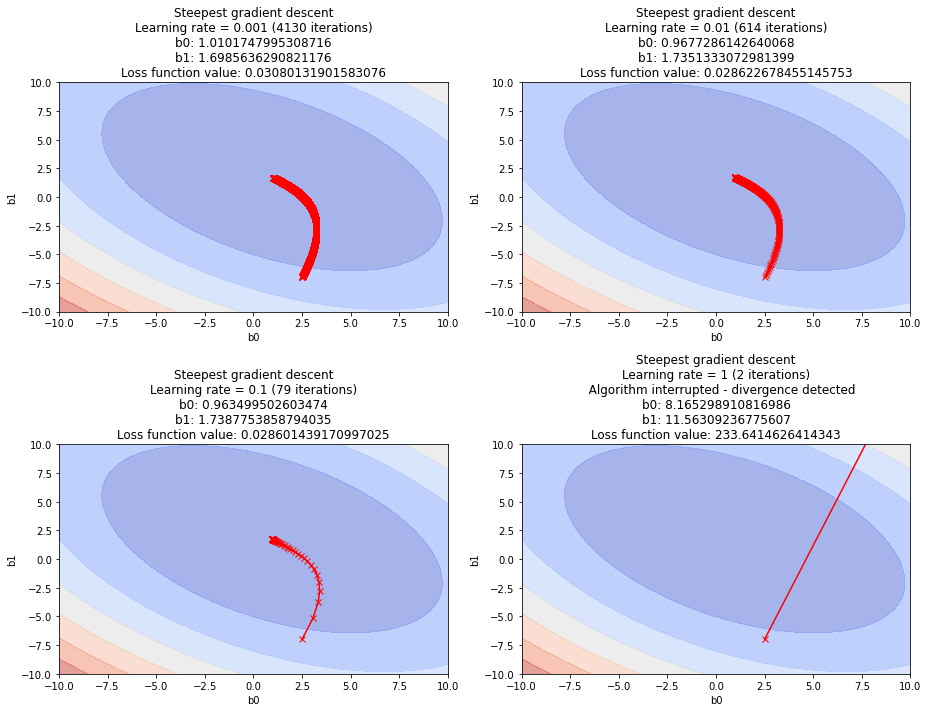

In [13]:
lrl.gradient_descent_2D(learning_rates = [0.001, 0.01, 0.1, 1], 
                        initial_p1_index = 2.5, 
                        initial_p2_index = -7)

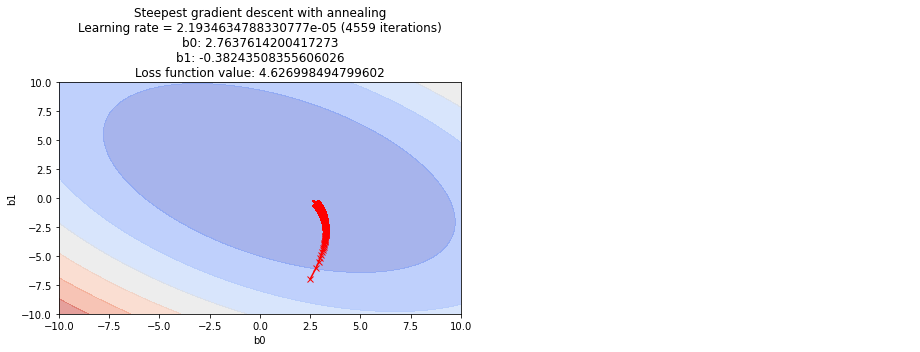

In [14]:
lrl.gradient_descent_2D(learning_rates = [0.1], 
                        initial_p1_index = 2.5, 
                        initial_p2_index = -7, 
                        method = 'annealing')

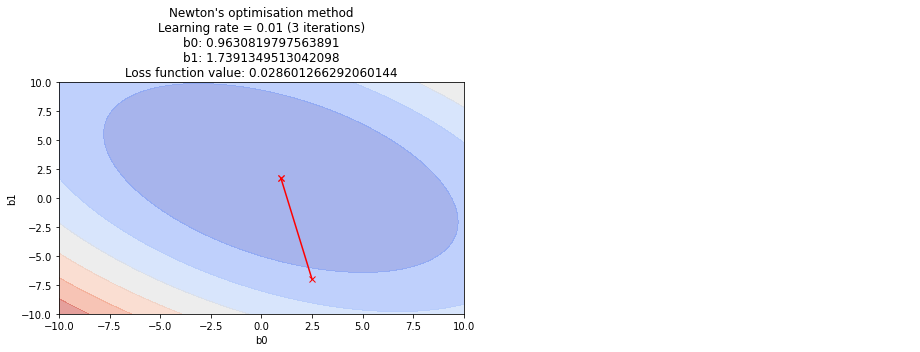

In [15]:
lrl.gradient_descent_2D(initial_p1_index = 2.5, 
                        initial_p2_index = -7, 
                        method = 'newton')

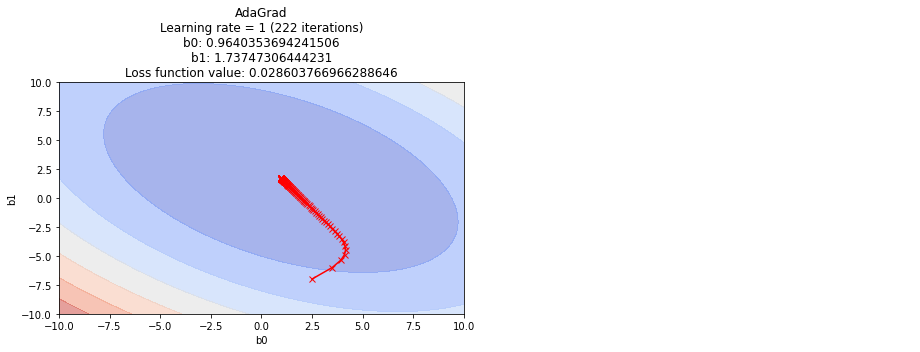

In [16]:
lrl.gradient_descent_2D(initial_p1_index = 2.5, 
                        initial_p2_index = -7, 
                        method = 'adagrad',
                        learning_rates = [1])

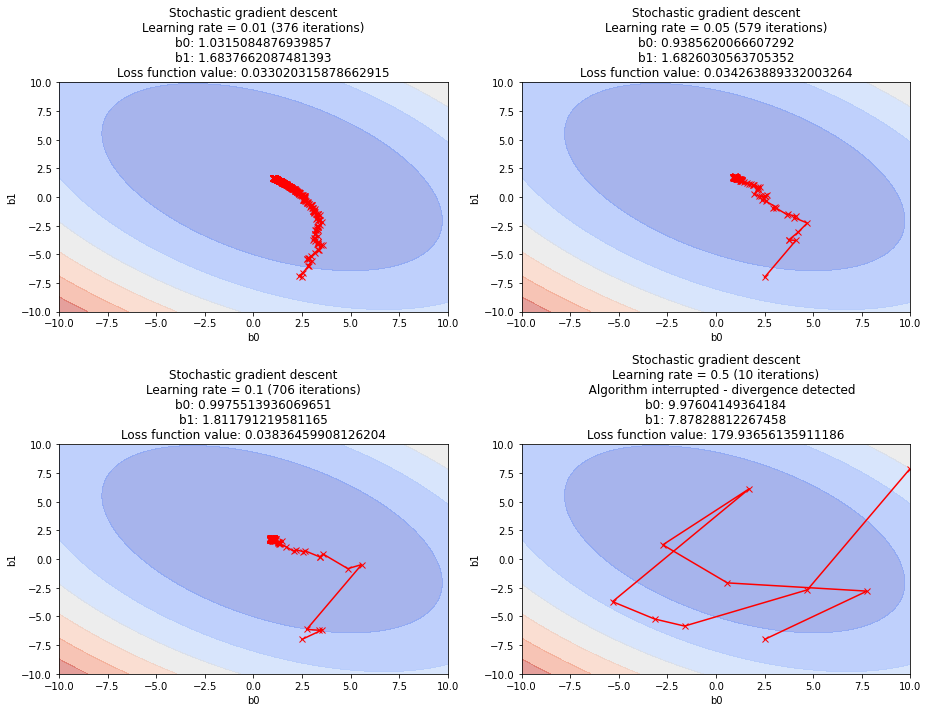

In [17]:
lrl.gradient_descent_2D(learning_rates = [0.01, 0.05, 0.1, 0.5], 
                        initial_p1_index = 2.5, 
                        initial_p2_index = -7,
                        method = 'sgd')

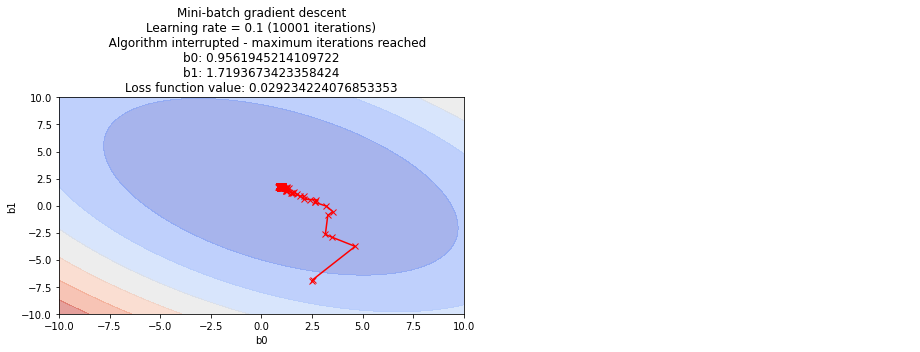

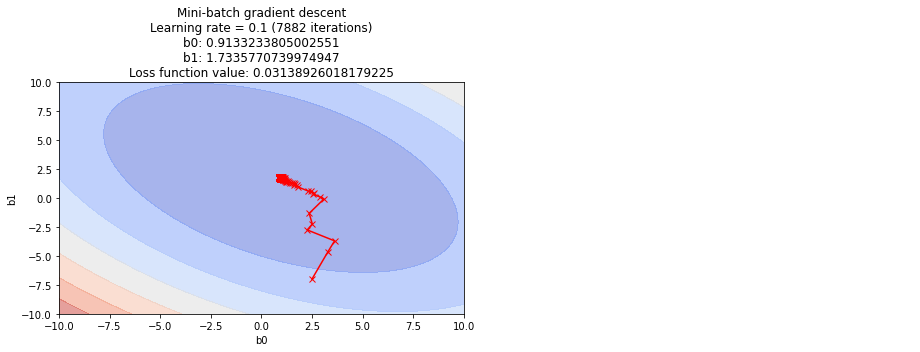

In [18]:
lrl.gradient_descent_2D(learning_rates = [0.1], 
                        initial_p1_index = 2.5, 
                        initial_p2_index = -7,
                        method = 'minibatch',
                        batch_size = 2)

lrl.gradient_descent_2D(learning_rates = [0.1], 
                        initial_p1_index = 2.5, 
                        initial_p2_index = -7,
                        method = 'minibatch',
                        batch_size = 5)

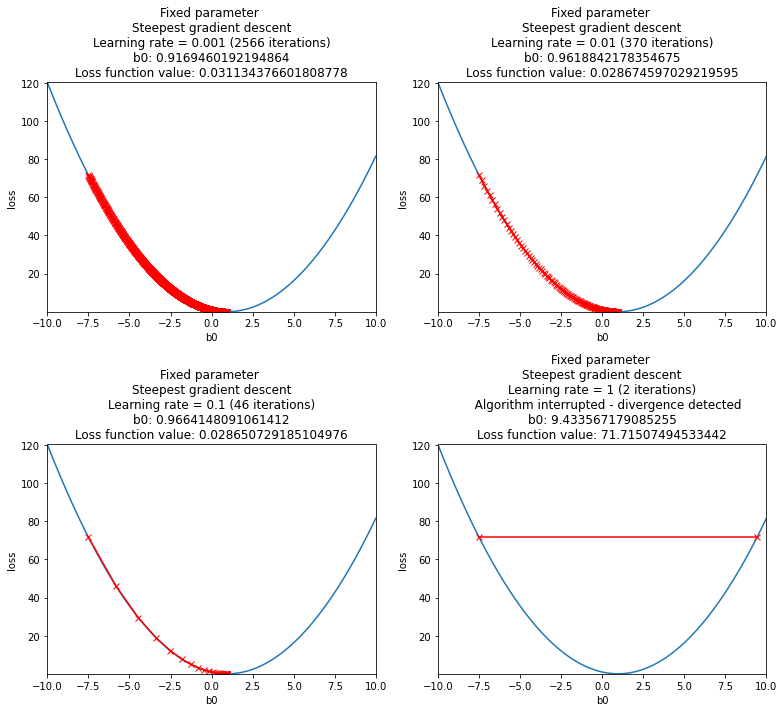

In [19]:
lrl.gradient_descent_1D(0, 586, -7.5, learning_rates = [0.001, 0.01, 0.1, 1])

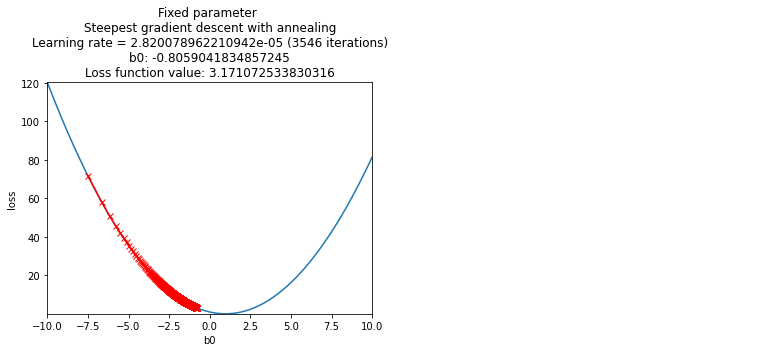

In [20]:
lrl.gradient_descent_1D(0, 586, -7.5, learning_rates = [0.1], method = 'annealing')

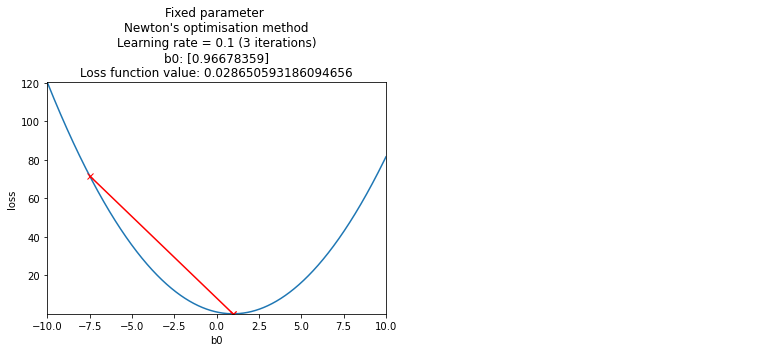

In [21]:
lrl.gradient_descent_1D(0, 586, -7.5, learning_rates = [0.1], method = 'newton')

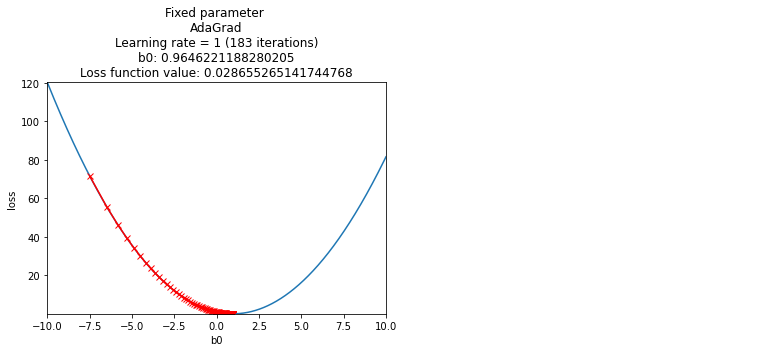

In [22]:
lrl.gradient_descent_1D(0, 586, -7.5, learning_rates = [1], method = 'adagrad')

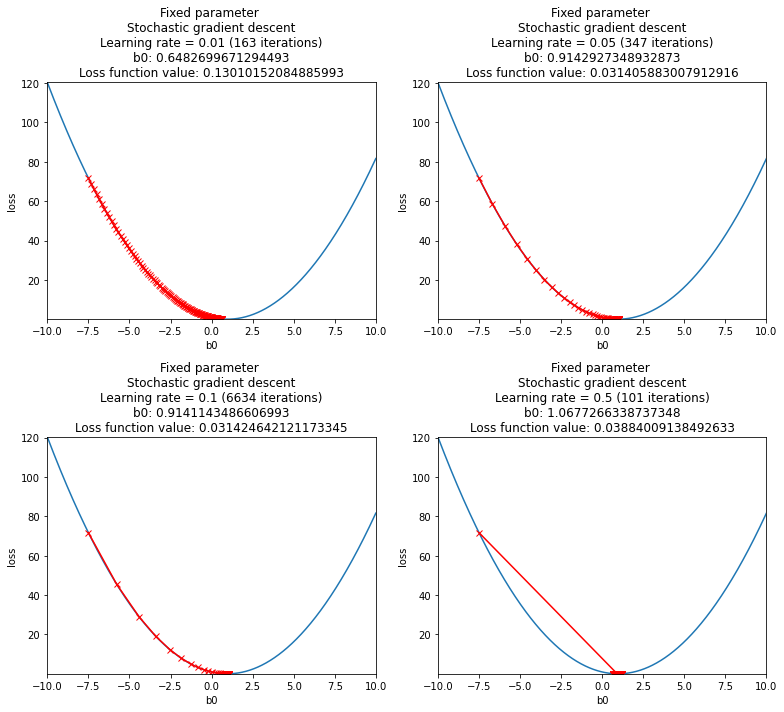

In [23]:
lrl.gradient_descent_1D(0, 
                        586, 
                        -7.5, 
                        learning_rates = [0.01, 0.05, 0.1, 0.5], 
                        method = 'sgd')

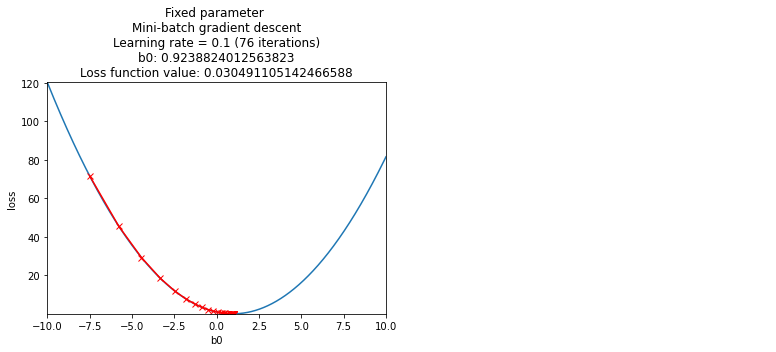

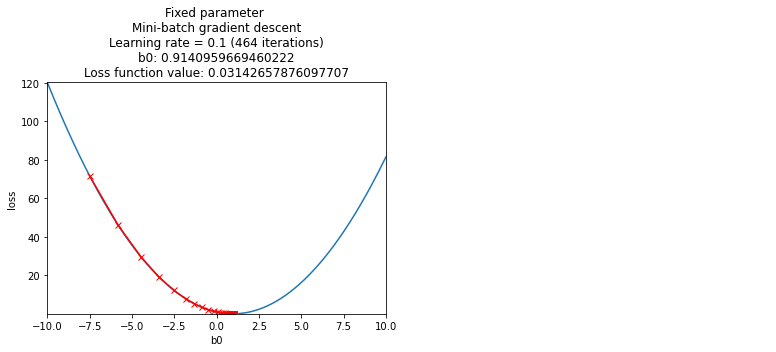

In [24]:
lrl.gradient_descent_1D(0, 
                        586, 
                        -7.5, 
                        learning_rates = [0.1],
                        method = 'minibatch', 
                        batch_size = 2)

lrl.gradient_descent_1D(0, 
                        586, 
                        -7.5, 
                        learning_rates = [0.1], 
                        method = 'minibatch', 
                        batch_size = 5)

## Logistic regression results

In [25]:
lgl = LogisticRegressionLoss(mu1 = -1,
                             std1 = 2,
                             n1 = 10,
                             mu2 = 1,
                             std2 = 2,
                             n2 = 10,
                             p1lim = [-1.5, 0.9],
                             p2lim = [0, 1.7])

In [26]:
lgl.produce_dataset()

In [27]:
lgl.calculate_loss_2D()

Gridsearch minimum:
b0: 0.13363363363363345
b1: 0.5598598598598599
Loss function value: 11.000398160911411


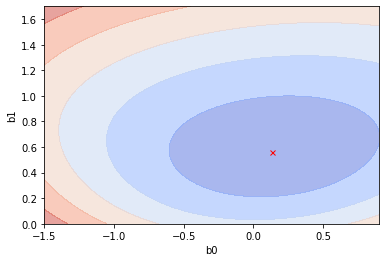

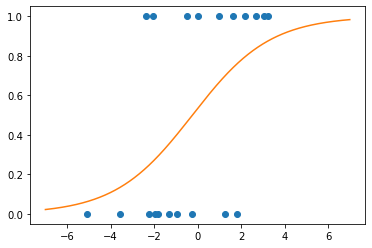

In [28]:
lgl.gridsearch_loss_2D()

Gridsearch minimum:
b0: 0.18168168168168153
Loss function value: 11.22294137298875


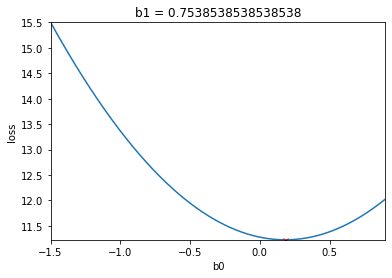

In [29]:
lgl.gridsearch_loss_1D(0, 443)

<ipython-input-6-4cbc81650592>:47: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.multiply(self.y, np.log(yp)) + np.multiply(1 - self.y, np.log(1 - yp)))
<ipython-input-6-4cbc81650592>:47: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.multiply(self.y, np.log(yp)) + np.multiply(1 - self.y, np.log(1 - yp)))


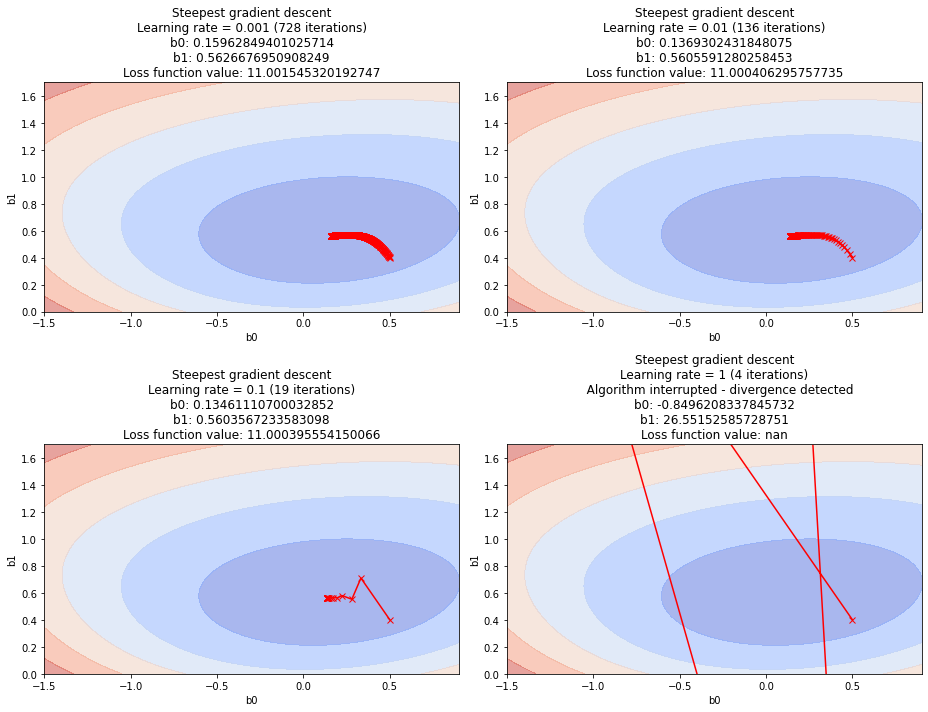

In [30]:
lgl.gradient_descent_2D(learning_rates = [0.001, 0.01, 0.1, 1], 
                        initial_p1_index = 0.5, 
                        initial_p2_index = 0.4)

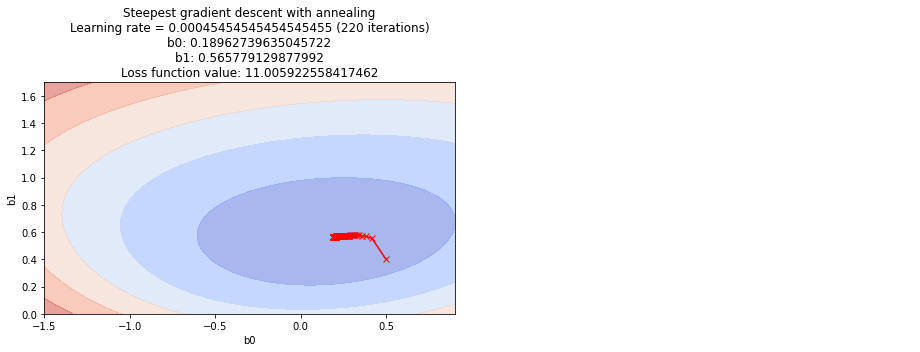

In [31]:
lgl.gradient_descent_2D(learning_rates = [0.1], 
                        initial_p1_index = 0.5, 
                        initial_p2_index = 0.4, 
                        method = 'annealing')

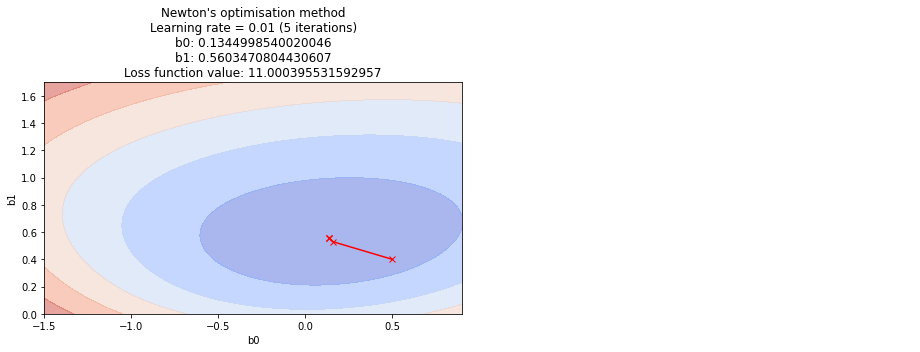

In [32]:
lgl.gradient_descent_2D(initial_p1_index = 0.5, 
                        initial_p2_index = 0.4, 
                        method = 'newton')

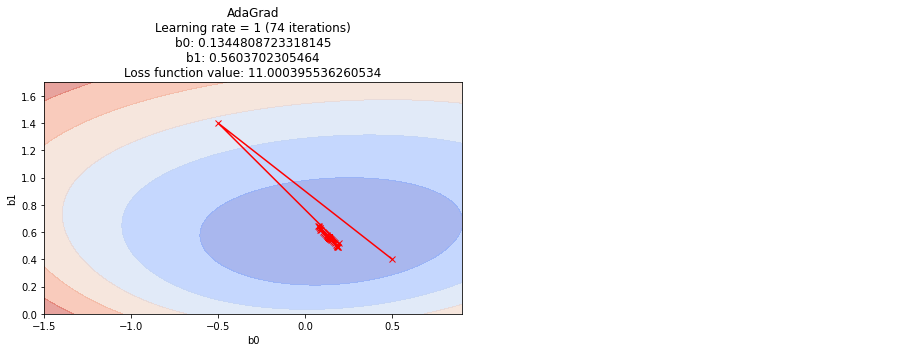

In [33]:
lgl.gradient_descent_2D(initial_p1_index = 0.5, 
                        initial_p2_index = 0.4, 
                        method = 'adagrad',
                        learning_rates = [1])

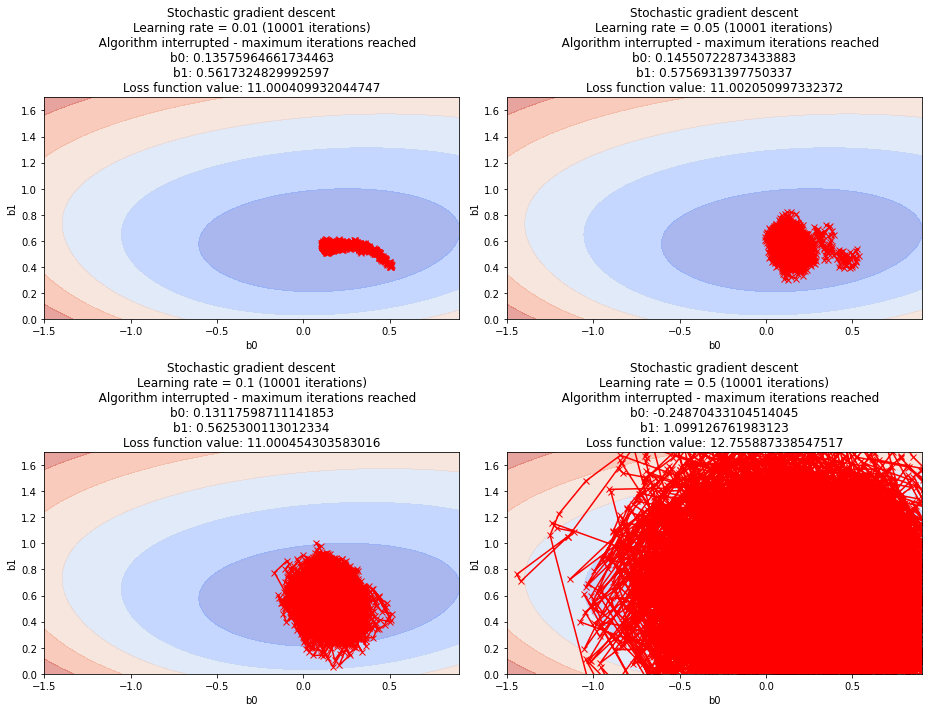

In [34]:
lgl.gradient_descent_2D(learning_rates = [0.01, 0.05, 0.1, 0.5], 
                        initial_p1_index = 0.5, 
                        initial_p2_index = 0.4,
                        method = 'sgd')

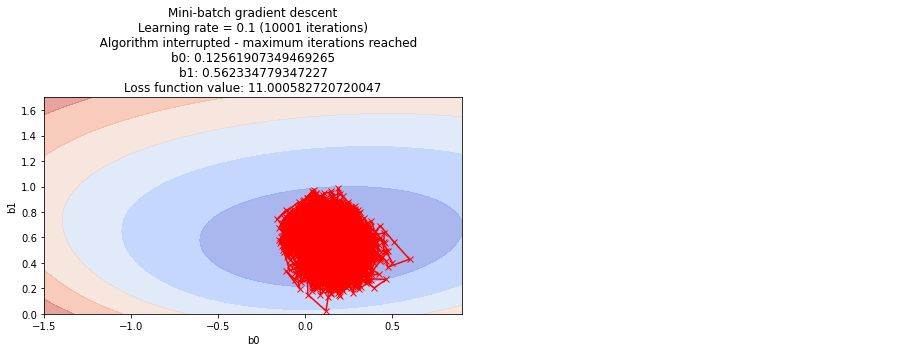

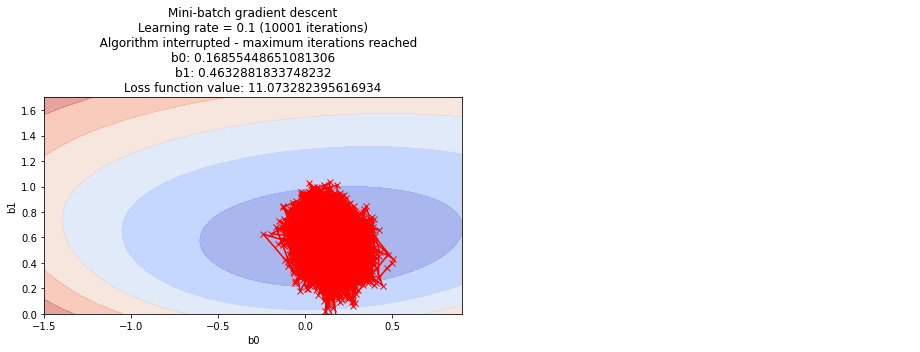

In [35]:
lgl.gradient_descent_2D(learning_rates = [0.1], 
                        initial_p1_index = 0.5, 
                        initial_p2_index = 0.4,
                        method = 'minibatch',
                        batch_size = 2)

lgl.gradient_descent_2D(learning_rates = [0.1], 
                        initial_p1_index = 0.5, 
                        initial_p2_index = 0.4,
                        method = 'minibatch',
                        batch_size = 5)

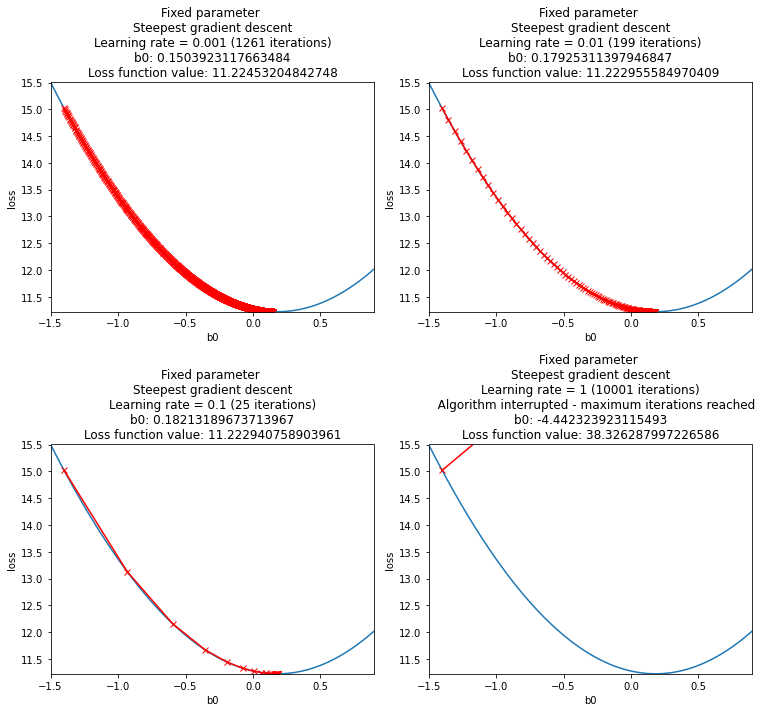

In [36]:
lgl.gradient_descent_1D(0, 443, -1.4, learning_rates = [0.001, 0.01, 0.1, 1])

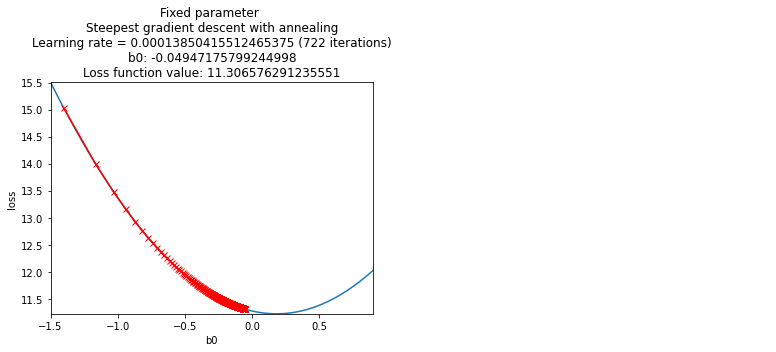

In [37]:
lgl.gradient_descent_1D(0, 443, -1.4, learning_rates = [0.1], method = 'annealing')

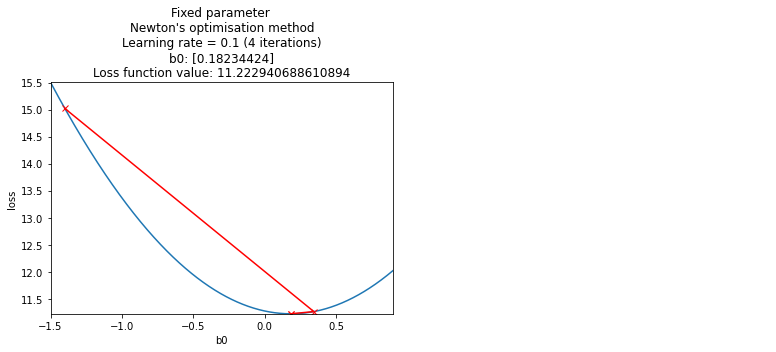

In [38]:
lgl.gradient_descent_1D(0, 443, -1.4, learning_rates = [0.1], method = 'newton')

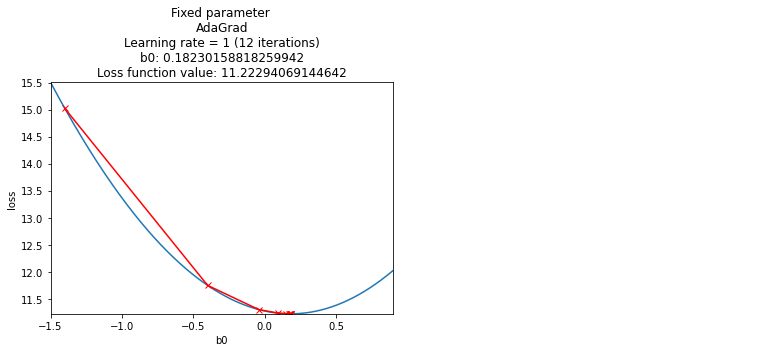

In [39]:
lgl.gradient_descent_1D(0, 443, -1.4, learning_rates = [1], method = 'adagrad')

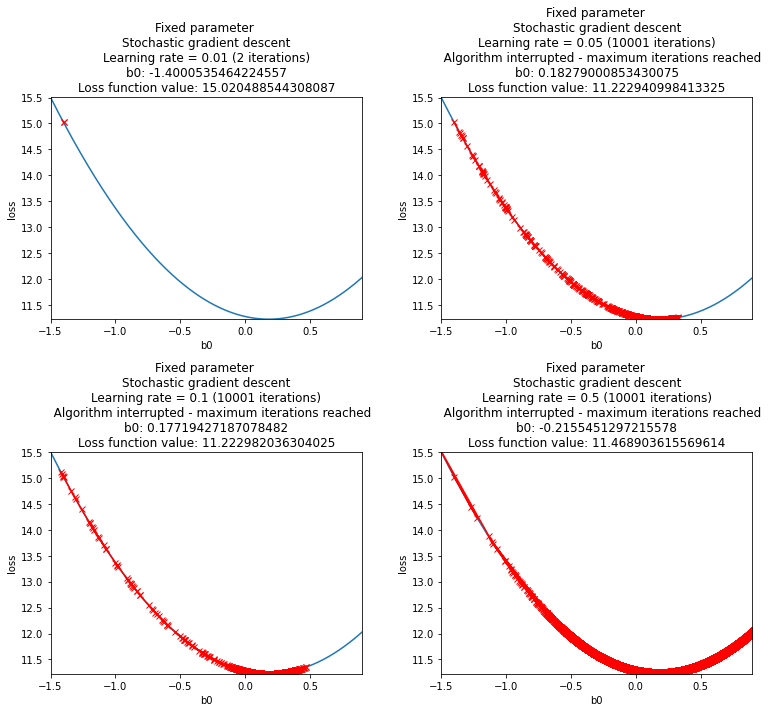

In [40]:
lgl.gradient_descent_1D(0, 
                        443, 
                        -1.4, 
                        learning_rates = [0.01, 0.05, 0.1, 0.5], 
                        method = 'sgd')

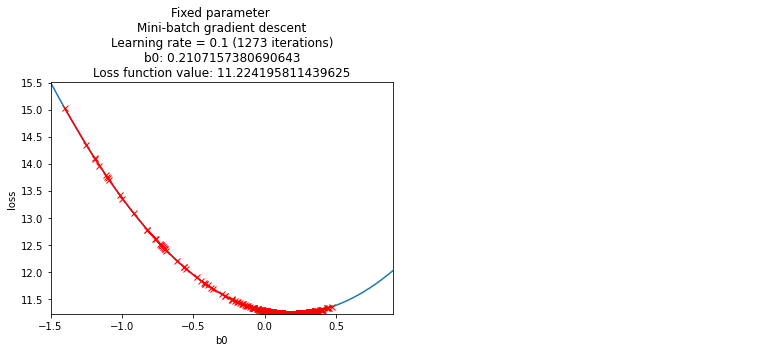

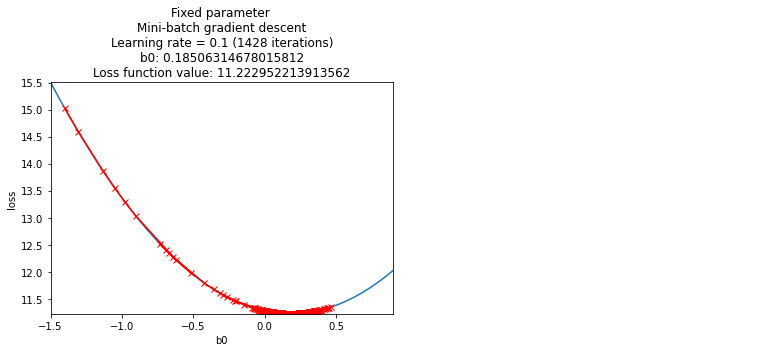

In [41]:
lgl.gradient_descent_1D(0, 
                        443, 
                        -1.4, 
                        learning_rates = [0.1], 
                        method = 'minibatch', 
                        batch_size = 2)

lgl.gradient_descent_1D(0, 
                        443, 
                        -1.4, 
                        learning_rates = [0.1], 
                        method = 'minibatch', 
                        batch_size = 5)

## Syblinski-Tang regression results

In [42]:
stl = StyblinskiTangLoss(p1lim = [-4, 4], p2lim = [-4, 4])

In [43]:
stl.produce_dataset()

In [44]:
stl.calculate_loss_2D()

Gridsearch minimum:
b1: -2.8708708708708706
b2: -3.095095095095095
Loss function value: 1315.9145852700888


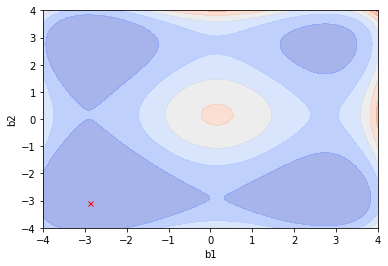

In [45]:
stl.gridsearch_loss_2D()

Gridsearch minimum:
b1: -2.9029029029029028
Loss function value: 55605.50162311895


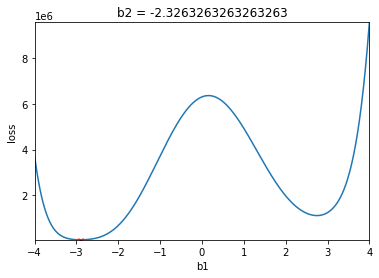

In [46]:
stl.gridsearch_loss_1D(0, 209)

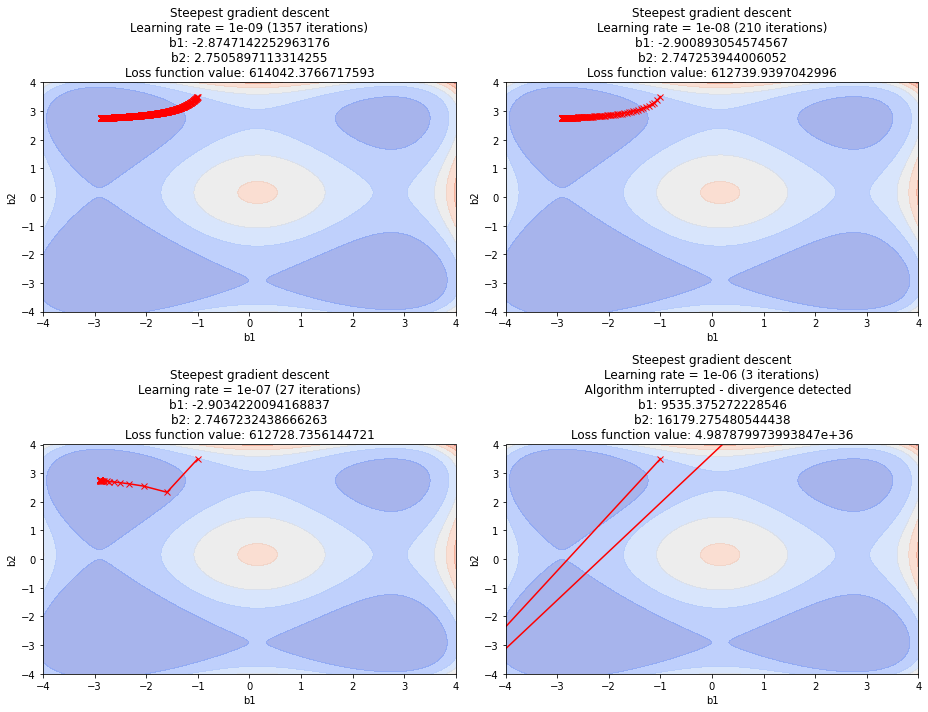

In [47]:
stl.gradient_descent_2D(learning_rates = [0.000000001, 0.00000001, 0.0000001, 0.000001], 
                        initial_p1_index = -1, 
                        initial_p2_index = 3.5)

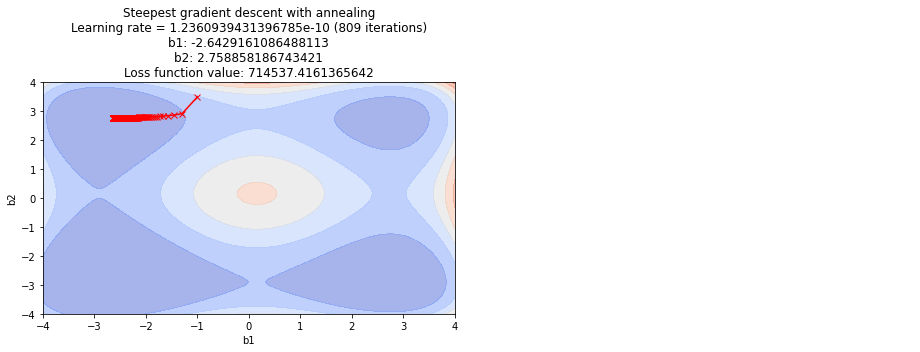

In [48]:
stl.gradient_descent_2D(learning_rates = [0.0000001], 
                        initial_p1_index = -1, 
                        initial_p2_index = 3.5, 
                        method = 'annealing')

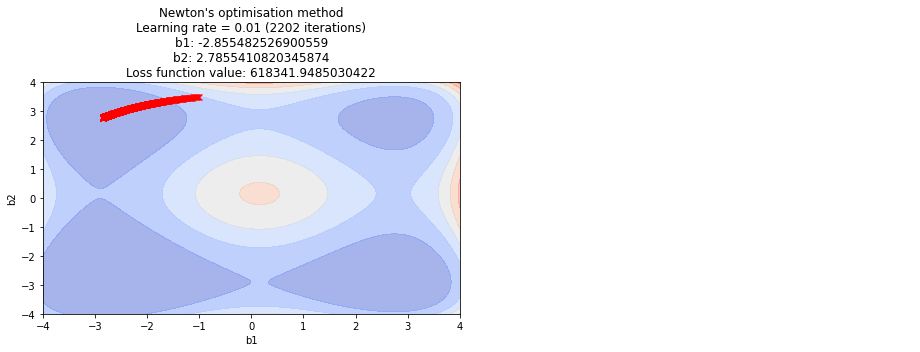

In [49]:
stl.gradient_descent_2D(initial_p1_index = -1, 
                        initial_p2_index = 3.5, 
                        method = 'newton')

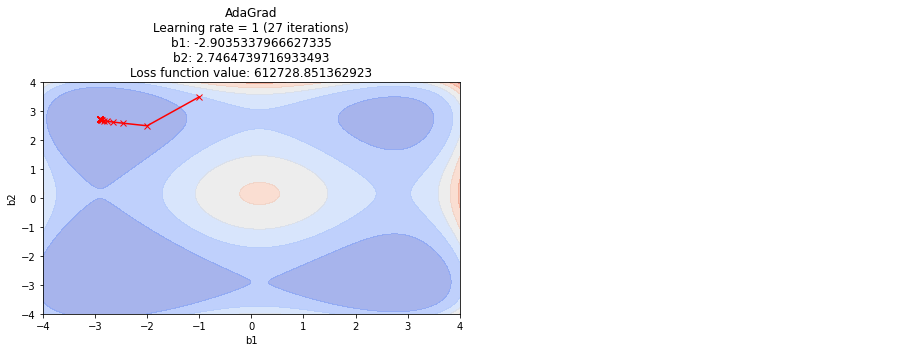

In [50]:
stl.gradient_descent_2D(learning_rates = [1],
                        initial_p1_index = -1, 
                        initial_p2_index = 3.5,
                        method = 'adagrad')

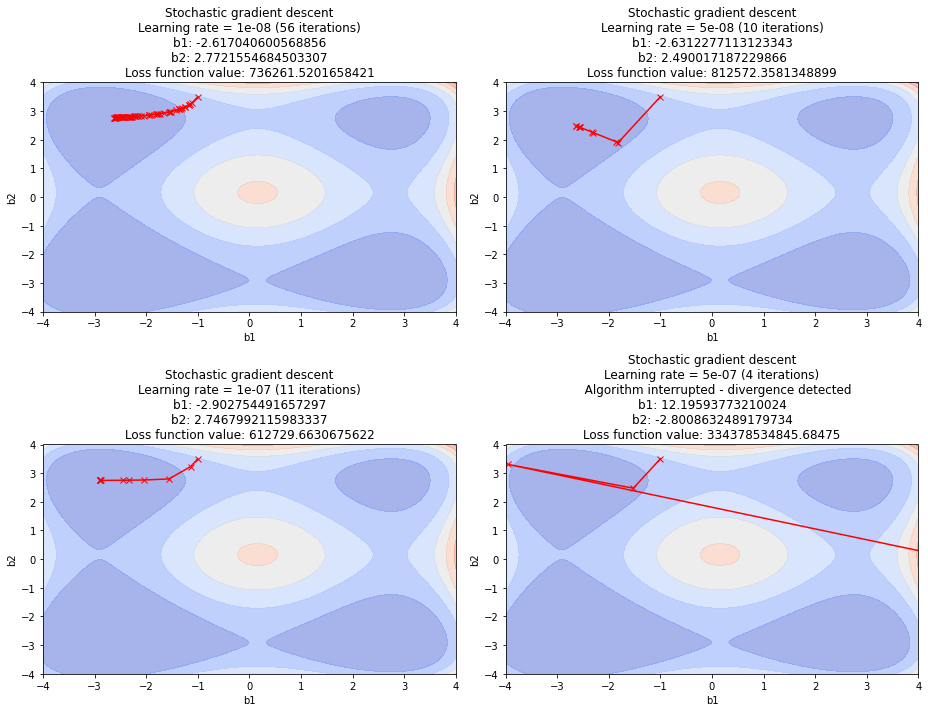

In [51]:
stl.gradient_descent_2D(learning_rates = [0.00000001, 0.00000005, 0.0000001, 0.0000005], 
                        initial_p1_index = -1, 
                        initial_p2_index = 3.5,
                        method = 'sgd')

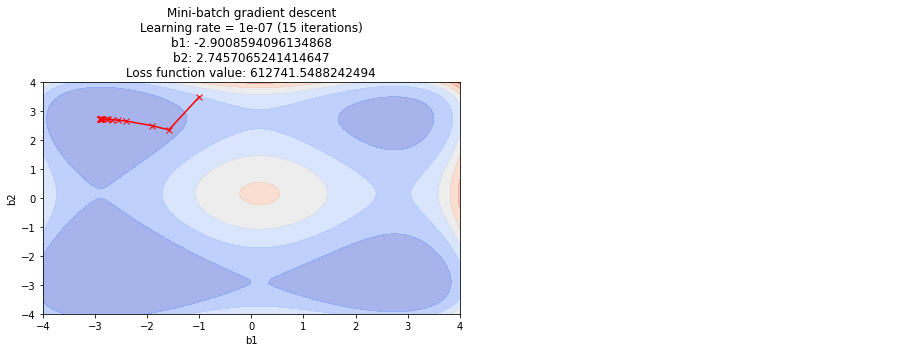

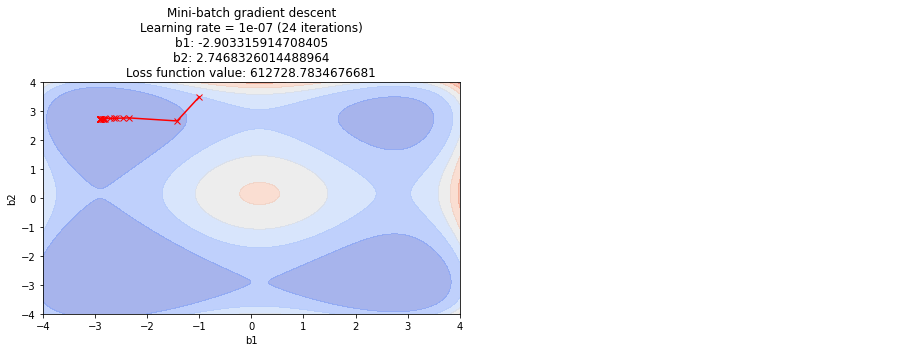

In [52]:
stl.gradient_descent_2D(learning_rates = [0.0000001], 
                        initial_p1_index = -1, 
                        initial_p2_index = 3.5,
                        method = 'minibatch',
                        batch_size = 2)

stl.gradient_descent_2D(learning_rates = [0.0000001], 
                        initial_p1_index = -1, 
                        initial_p2_index = 3.5,
                        method = 'minibatch',
                        batch_size = 5)

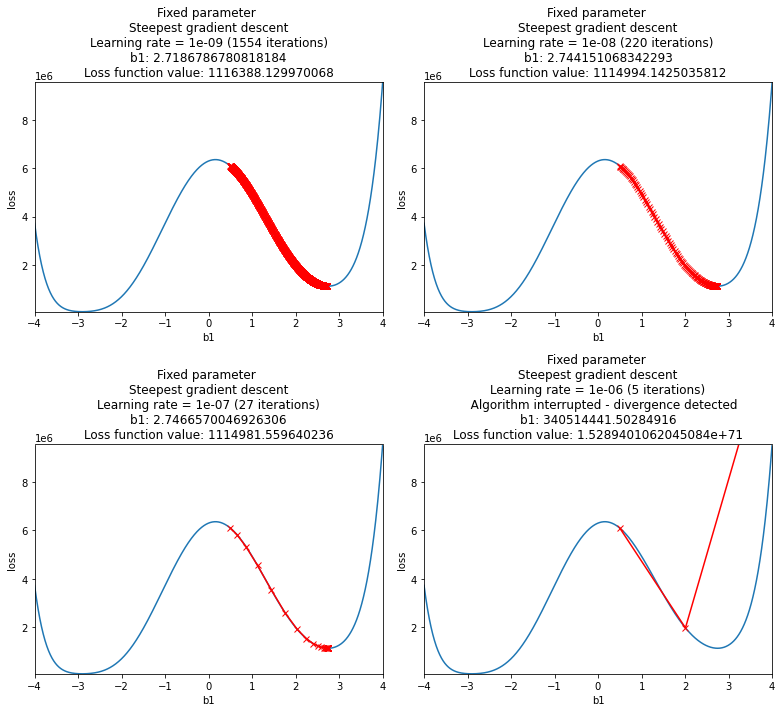

In [53]:
stl.gradient_descent_1D(0, 
                        209, 
                        0.5, 
                        learning_rates = [0.000000001, 
                                          0.00000001, 
                                          0.0000001, 
                                          0.000001])

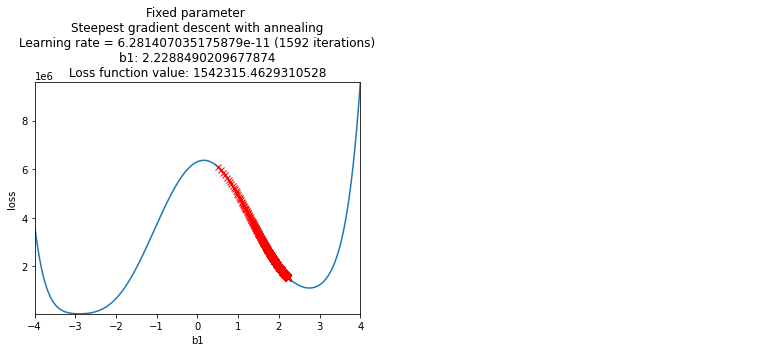

In [54]:
stl.gradient_descent_1D(0, 
                        209, 
                        0.5, 
                        learning_rates = [0.0000001], 
                        method = 'annealing')

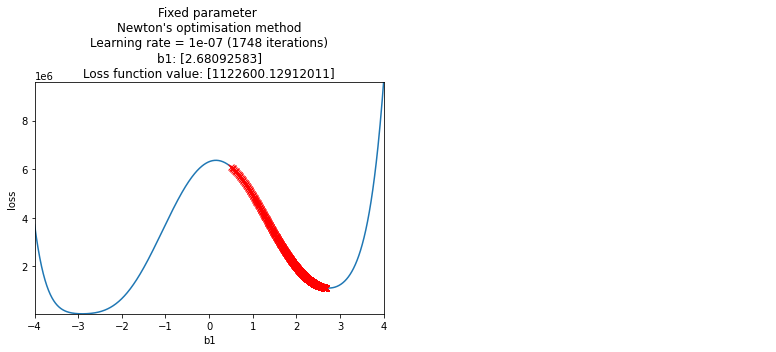

In [55]:
stl.gradient_descent_1D(0, 209, 0.5, learning_rates = [0.0000001], method = 'newton')

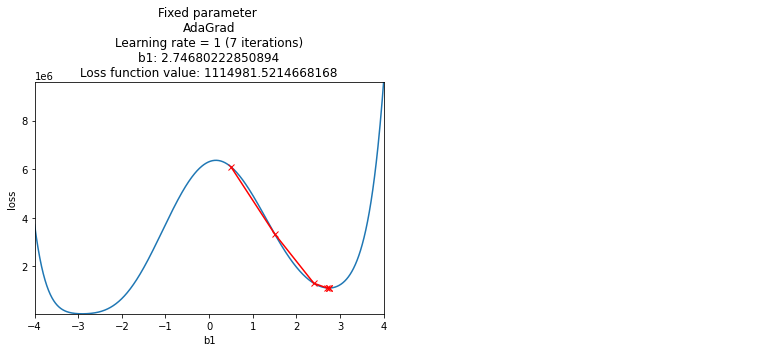

In [56]:
stl.gradient_descent_1D(0, 209, 0.5, learning_rates = [1], method = 'adagrad')

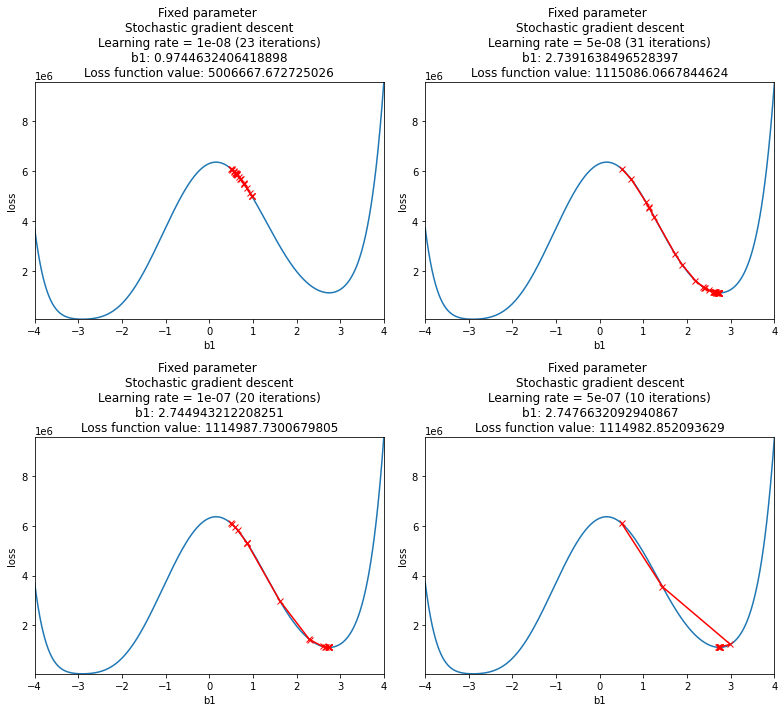

In [57]:
stl.gradient_descent_1D(0, 
                        209, 
                        0.5, 
                        learning_rates = [0.00000001, 
                                          0.00000005, 
                                          0.0000001, 
                                          0.0000005], 
                        method = 'sgd')

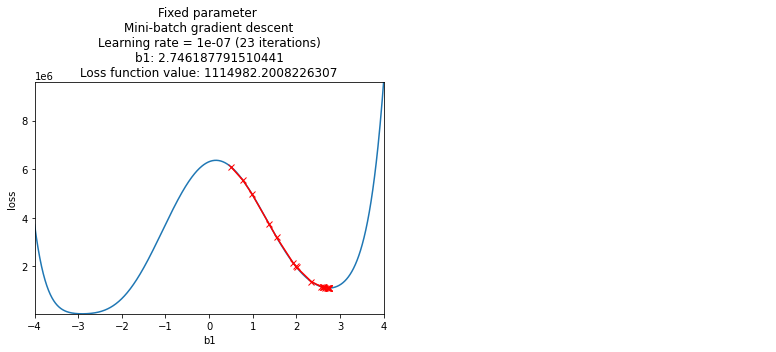

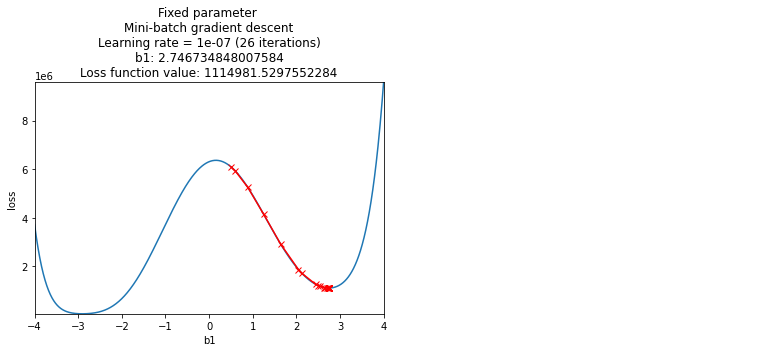

In [58]:
stl.gradient_descent_1D(0, 
                        209, 
                        0.5, 
                        learning_rates = [0.0000001], 
                        method = 'minibatch', 
                        batch_size = 2)

stl.gradient_descent_1D(0, 
                        209, 
                        0.5, 
                        learning_rates = [0.0000001], 
                        method = 'minibatch', 
                        batch_size = 5)

## Conclusions

In these results we compare the execution of all the implemented gradient descent methods for the three loss functions in the notebook. This comparison is based on a single execution, so these results should be taken with a pinch of salt.

### 2D linear regression

In this particular case we include the conjugate gradient descent results from the second notebook. 

| algorithm     | learning rate | number iterations | notes                    |
|---------------|---------------|-------------------|--------------------------|
| steepest      | 0.001         | 4130              | Slightly off the minimum |
| steepest      | 0.01          | 614               |                          |
| steepest      | 0.1           | 79                |                          |
| steepest      | 1             |                   | Diverges                 |
| annealing     | 0.1           | 4559              | Early stop               |
| newton        | 0.01          | 3                 |                          | 
| adagrad       | 1             | 222               |                          |
| sgd           | 0.01          | 376               | Slightly off the minimum |
| sgd           | 0.05          | 579               |                          |
| sgd           | 0.1           | 706               |                          |
| sgd           | 1             |                   | Diverges                 |
| minibatch (2) | 0.1           |                   | Doesn't converge         |
| minibatch (5) | 0.1           | 7882              |                          |
| conjugate     |               | 2                 |                          |

The obvious best results are obtained by applying conjugate gradient descent (see the second notebook in this folder). Unfortunately, not all loss functions can be expressed in terms of a system of linear equations as it is the case with linear regression's loss function. 

Besides this method, stochastic gradient descent (with some Newton or Adagrad iterations at the end) seems to be the best option. The number of iterations is low, and we only consider a single observation at each iteration. Therefore, execution time will be faster.

Adagrad may be a safe bet if we are unsure about which learning rate we should be using. 

### 1D linear regression

| algorithm     | learning rate | number iterations | notes                    |
|---------------|---------------|-------------------|--------------------------|
| steepest      | 0.001         | 2566              | Slightly off the minimum |
| steepest      | 0.01          | 360               |                          | 
| steepest      | 0.1           | 46                |                          |
| steepest      | 1             |                   | Diverges                 |
| annealing     | 0.1           | 3546              | Early stop               |
| newton        | 0.1           | 3                 |                          |
| adagrad       | 1             | 183               |                          |
| sgd           | 0.01          | 163               | Early stop               |
| sgd           | 0.05          | 347               | Slightly off the minimum |
| sgd           | 0.1           | 6634              | Slightly off the minimum |
| sgd           | 0.5           | 101               | Slightly off the minimum |
| minibatch (2) | 0.1           | 76                | Slightly off the minimum |
| minibatch (5) | 0.1           | 464               | Slightly off the minimum |

In this particular case, stochastic gradient descent doesn't seem to be doing very well. The number of iterations and how far we end from the minimum seem to be very sensitive to the learning rate. Adagrad seems to once again perform the best, not just because the number of iterations lies in the lower side of the spectrum when compared to other methods, but also because we don't have to worry much about the learning rate value. 

### 2D logistic regression

| algorithm     | learning rate | number iterations | notes                    |
|---------------|---------------|-------------------|--------------------------|
| steepest      | 0.001         | 728               |                          |
| steepest      | 0.01          | 136               |                          |
| steepest      | 0.1           | 19                |                          |
| steepest      | 1             |                   | Diverges                 |
| annealing     | 0.1           | 220               |                          |
| newton        | 0.01          | 5                 |                          |
| adagrad       | 1             | 74                |                          | 
| sgd           | 0.01          |                   | Doesn't converge         |
| sgd           | 0.05          |                   | Doesn't converge         |
| sgd           | 0.1           |                   | Doesn't converge         |
| sgd           | 0.5           |                   | Doesn't converge         |
| minibacth (2) | 0.1           |                   | Doesn't converge         |
| minibatch (5) | 0.1           |                   | Doesn't converge         |

Stochastic and minibatch methods don't get to converge in the case of the logistic regression's loss function, which is based on a sum instead than on an average. Adagrad seems to be best, unless we can afford fine-tuning the learning rate in the steepest gradient descent algorithm. 

### 1D logistic regression

| algorithm     | learning rate | number iterations | notes                    |
|---------------|---------------|-------------------|--------------------------|
| steepest      | 0.001         | 1261              |                          |
| steepest      | 0.01          | 199               |                          |
| steepest      | 0.1           | 25                |                          |
| steepest      | 1             |                   | Diverges                 | 
| annealing     | 0.1           | 722               | Slightly off the minimum |
| newton        | 0.1           | 4                 |                          |
| adagrad       | 1             | 12                |                          |
| sgd           | 0.01          |                   | Early stop               |
| sgd           | 0.05          |                   | Does not converge        |
| sgd           | 0.1           |                   | Does not converge        |
| sgd           | 0.5           |                   | Does not converge        |
| minibatch (2) | 0.1           | 1273              |                          |
| minibatch (5) | 0.1           | 1428              |                          |

Minibatch does converge in the 1D case, but at the expense of requiring a very high number of iterations if we compare to the other algorithms. Once again, Adagrad seems to be the best algorithm, followed by steepest + Newton.


### 2D Styblinski-Tang regression

The global minimum was never reached neither in the 2D case nor in the 1D case. Only in some specific instances (depending on the value of the random seed) we got stochastic gradient descent to converge to the global minimum in the 2D case.

| algorithm     | learning rate | number iterations | notes                            |
|---------------|---------------|-------------------|----------------------------------|
| steepest      | 0.000000001   | 1357              | Slightly off the (local) minimum |
| steepest      | 0.00000001    | 210               |                                  |
| steepest      | 0.0000001     | 27                |                                  |
| steepest      | 0.000001      |                   | Diverges                         |
| annealing     | 0.0000001     | 809               | Early stop                       |
| newton        | 0.01          | 2202              |                                  |
| adagrad       | 1             | 27                |                                  |
| sgd           | 0.00000001    | 56                | Early stop                       |
| sgd           | 0.00000005    | 10                | Early stop                       |
| sgd           | 0.0000001     | 11                |                                  |
| sgd           | 0.0000005     |                   | Diverges                         |
| minibatch (2) | 0.0000001     | 15                |                                  |
| minibatch (5) | 0.0000001     | 24                |                                  |

Stochastic gradient descent seems to be the best option, but the final loss function value is very sensitive to the learning rate. It would be best to combine this method with a few Adagrad steps at the end. 

### 1D Styblinski-Tang regression

| algorithm     | learning rate | number iterations | notes                    |
|---------------|---------------|-------------------|--------------------------|
| steepest      | 0.000000001   | 1554              |                          |
| steepest      | 0.00000001    | 220               |                          |
| steepest      | 0.0000001     | 27                |                          |
| steepest      | 0.000001      |                   | Diverges                 |
| annealing     | 0.0000001     | 1592              | Early stop               |
| newton        | 0.0000001     | 1748              |                          |
| adagrad       | 1             | 7                 |                          |
| sgd           | 0.00000001    | 23                | Early stop               |
| sgd           | 0.00000005    | 31                |                          |
| sgd           | 0.0000001     | 20                |                          |
| sgd           | 0.0000005     | 10                |                          |
| minibatch (2) | 0.0000001     | 23                |                          |
| minibatch (5) | 0.0000001     | 26                |                          |


In this case the stochastic gradient descent results are not that sensitive to the learning rate value, but it may still be useful to finalise the process with some Adagrad steps. 
